<IPython.core.display.Javascript object>


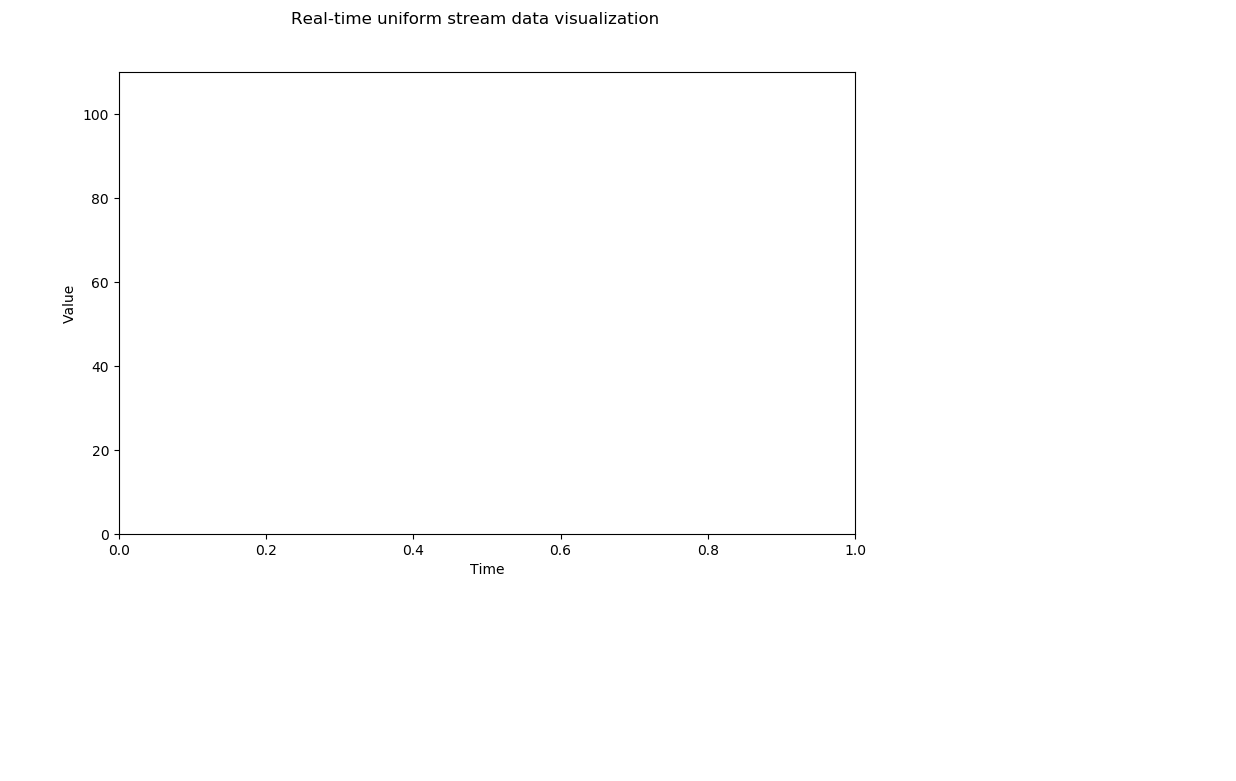

In [ ]:
# import statements
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.0 pyspark-shell'

from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

x, y, y2 = [], [], []
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        global x
        global y
        global y2
        # print('Waiting for messages')
        for message in consumer.collect():
            print('*'* 40)
            print(message)
            print('*'* 40)
            data = message
            #data = str(message.value.decode('utf-8')).split(', ')
            x.append(data['created_at']) 
            y.append(min(y + [data['air_temperature_celcius']]))
            y2.append(max(y + [data['air_temperature_celcius']]))
            # print(y)
            # we start plotting only when we have 10 data points
        if len(y) >= 10:
            ax.clear()
            ax.plot(x, y)
            ax.plot(x, y2)
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
            ax.set_ylim(0,80) 
            ax.set_yticks([0,20,40,60,80,100])
            fig.canvas.draw()
            x.pop(0) # removing the item in the first position
            y.pop(0)
            y2.pop(0)
        #plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    fig, ax = init_plots()
    topic = ['climate']
    n_secs = 1
    conf = SparkConf().setAppName("KafkaStreamProcessor")
    sc = SparkContext.getOrCreate()
    if sc is None:
        sc = SparkContext(conf=conf)
    sc.setLogLevel("WARN")
    ssc = StreamingContext(sc, n_secs)
    
    kafkaStream = KafkaUtils.createDirectStream(ssc,topic , {
            'bootstrap.servers':'localhost:9092', 
            })
    lines = kafkaStream.map(lambda x: json.loads(x[1]))
# lines.pprint()
    fore = lines.foreachRDD(lambda x: consume_messages(x, fig, ax))
    ssc.start()
    ssc.awaitTermination()
    
#     consume_messages(consumer, fig, ax)
    
    